In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(n=1, engines="mpi")
rc = cluster.start_and_connect_sync(activate=True)

Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/1 [00:00<?, ?engine/s]

In [2]:
def apply_imports(cluster):
    with cluster[:].sync_imports():
        import dolfinx
        from mpi4py import MPI
        import time
        import ufl
        import numpy


In [3]:
def solve_poisson(N):
    start = time.perf_counter()
    mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, N, N)
    V = dolfinx.fem.FunctionSpace(mesh, ("Lagrange", 1))
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx   
    x = ufl.SpatialCoordinate(mesh)
    f = ufl.cos(2*ufl.pi*x[0])
    L = ufl.inner(f, v) * ufl.dx
    mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
    bndry_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
    bndry_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, bndry_facets)
    bc = [dolfinx.fem.dirichletbc(numpy.float64(0), bndry_dofs, V)]
    petsc_options = {"ksp_type":"cg",
                     "pc_type": "hypre",
                     "pc_hypre_type": "boomeramg"}
    problem = dolfinx.fem.petsc.LinearProblem(a, L,bc, petsc_options=petsc_options)
    uh = problem.solve()
    end = time.perf_counter()
    local_cntr = dolfinx.fem.assemble_scalar(dolfinx.fem.form(uh*uh*ufl.dx))
    global_cntr = mesh.comm.reduce(local_cntr, op=MPI.SUM, root=0)
    if mesh.comm.rank == 0:
        print("u^2: ", global_cntr)
    return end-start


In [4]:
apply_imports(rc)

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)


In [5]:
result_serial = rc[:].apply_async(solve_poisson, 300)
result_serial.wait()
print(result_serial.stdout)
await cluster.stop_engines()

['']
Stopping engine(s): 1681659092


INFO:ipyparallel.cluster.cluster.1681659091-3qc1:Stopping engine(s): 1681659092


engine set stopped 1681659092: {'exit_code': 59, 'pid': 22653, 'identifier': 'ipengine-1681659091-3qc1-1681659092-22571'}


In [6]:
import numpy
mpi_processes = [1,2,4,6]
runtimes = numpy.zeros(len(mpi_processes))
for i, processes in enumerate(mpi_processes):
    cluster = ipp.Cluster(n=processes, engines="mpi")
    rc = cluster.start_and_connect_sync(activate=True)
    apply_imports(rc)
    process_runtimes = rc[:].apply_async(solve_poisson, 300)
    process_runtimes.wait()
    runtimes[i] = numpy.sum(process_runtimes.get())/len(process_runtimes.get()  )
    print(runtimes[i], process_runtimes.stdout)
    await cluster.stop_engines()

Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1681659102-lv28:Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/1 [00:00<?, ?engine/s]

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)
0.9997380390004764 ['']
Stopping engine(s): 1681659103


INFO:ipyparallel.cluster.cluster.1681659102-lv28:Stopping engine(s): 1681659103


Failed to remove /root/.ipython/profile_default/log/ipengine-1681659102-lv28-1681659103-22571.log: [Errno 2] No such file or directory: '/root/.ipython/profile_default/log/ipengine-1681659102-lv28-1681659103-22571.log'


ERROR:ipyparallel.cluster.cluster.1681659102-lv28:Failed to remove /root/.ipython/profile_default/log/ipengine-1681659102-lv28-1681659103-22571.log: [Errno 2] No such file or directory: '/root/.ipython/profile_default/log/ipengine-1681659102-lv28-1681659103-22571.log'


engine set stopped 1681659103: {'exit_code': 0, 'pid': 22815, 'identifier': 'ipengine-1681659102-lv28-1681659103-22571'}


INFO:ipyparallel.cluster.cluster.1681659102-lv28:engine set stopped 1681659103: {'exit_code': 0, 'pid': 22815, 'identifier': 'ipengine-1681659102-lv28-1681659103-22571'}


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1681659110-t2rd:Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)
0.9467570429997068 ['', '']
Stopping engine(s): 1681659111


INFO:ipyparallel.cluster.cluster.1681659110-t2rd:Stopping engine(s): 1681659111


Failed to remove /root/.ipython/profile_default/log/ipengine-1681659110-t2rd-1681659111-22571.log: [Errno 2] No such file or directory: '/root/.ipython/profile_default/log/ipengine-1681659110-t2rd-1681659111-22571.log'


ERROR:ipyparallel.cluster.cluster.1681659110-t2rd:Failed to remove /root/.ipython/profile_default/log/ipengine-1681659110-t2rd-1681659111-22571.log: [Errno 2] No such file or directory: '/root/.ipython/profile_default/log/ipengine-1681659110-t2rd-1681659111-22571.log'


mpiexec error output:
=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 22953 RUNNING AT c423b0c556db
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 22953 RUNNING AT c423b0c556db
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



engine set stopped 1681659111: {'exit_code': 139, 'pid': 22950, 'identifier': 'ipengine-1681659110-t2rd-1681659111-22571'}


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1681659119-5zpj:Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)
2.003656979499965 ['', '', '', '']
Stopping engine(s): 1681659120


INFO:ipyparallel.cluster.cluster.1681659119-5zpj:Stopping engine(s): 1681659120


mpiexec error output:
=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 23119 RUNNING AT c423b0c556db
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 23119 RUNNING AT c423b0c556db
=   EXIT CODE: 139
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



Failed to remove /root/.ipython/profile_default/log/ipengine-1681659119-5zpj-1681659120-22571.log: [Errno 2] No such file or directory: '/root/.ipython/profile_default/log/ipengine-1681659119-5zpj-1681659120-22571.log'


ERROR:ipyparallel.cluster.cluster.1681659119-5zpj:Failed to remove /root/.ipython/profile_default/log/ipengine-1681659119-5zpj-1681659120-22571.log: [Errno 2] No such file or directory: '/root/.ipython/profile_default/log/ipengine-1681659119-5zpj-1681659120-22571.log'


engine set stopped 1681659120: {'exit_code': 139, 'pid': 23116, 'identifier': 'ipengine-1681659119-5zpj-1681659120-22571'}


Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1681659129-r75p:Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

importing dolfinx on engine(s)
importing MPI from mpi4py on engine(s)
importing time on engine(s)
importing ufl on engine(s)
importing numpy on engine(s)
3.0567922186666387 ['', '', '', '', '', '']
Stopping engine(s): 1681659130


INFO:ipyparallel.cluster.cluster.1681659129-r75p:Stopping engine(s): 1681659130


Failed to remove /root/.ipython/profile_default/log/ipengine-1681659129-r75p-1681659130-22571.log: [Errno 2] No such file or directory: '/root/.ipython/profile_default/log/ipengine-1681659129-r75p-1681659130-22571.log'


ERROR:ipyparallel.cluster.cluster.1681659129-r75p:Failed to remove /root/.ipython/profile_default/log/ipengine-1681659129-r75p-1681659130-22571.log: [Errno 2] No such file or directory: '/root/.ipython/profile_default/log/ipengine-1681659129-r75p-1681659130-22571.log'


mpiexec error output:
=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 23356 RUNNING AT c423b0c556db
=   EXIT CODE: 9
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 23356 RUNNING AT c423b0c556db
=   EXIT CODE: 9
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Segmentation fault (signal 11)



engine set stopped 1681659130: {'exit_code': 139, 'pid': 23353, 'identifier': 'ipengine-1681659129-r75p-1681659130-22571'}


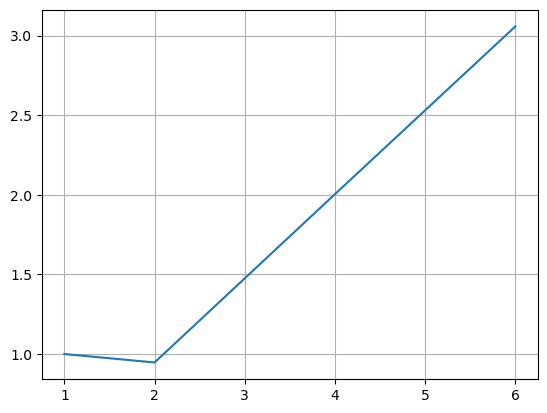

In [7]:
import matplotlib.pyplot as plt
plt.plot(mpi_processes, runtimes)
plt.grid()